# Домашняя работа по теме «Модели авторегрессии условной гетероскедантичности»

In [7]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 15.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model as smta
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Функция для теста Дики-Фуллера
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
# Функция для визуализации временного ряда
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [12]:
# Функция для поиска лучшей модели ARIMA
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    # Указываем тренд при создании модели
                    tmp_mdl = smta.ARIMA(TS, order=(i, d, j)).fit()
                    tmp_aic = tmp_mdl.aic

                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except Exception as e:
                    #print(f'Error for order {(i, d, j)}: {e}')
                    continue
    print('Best model: aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [28]:
series = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


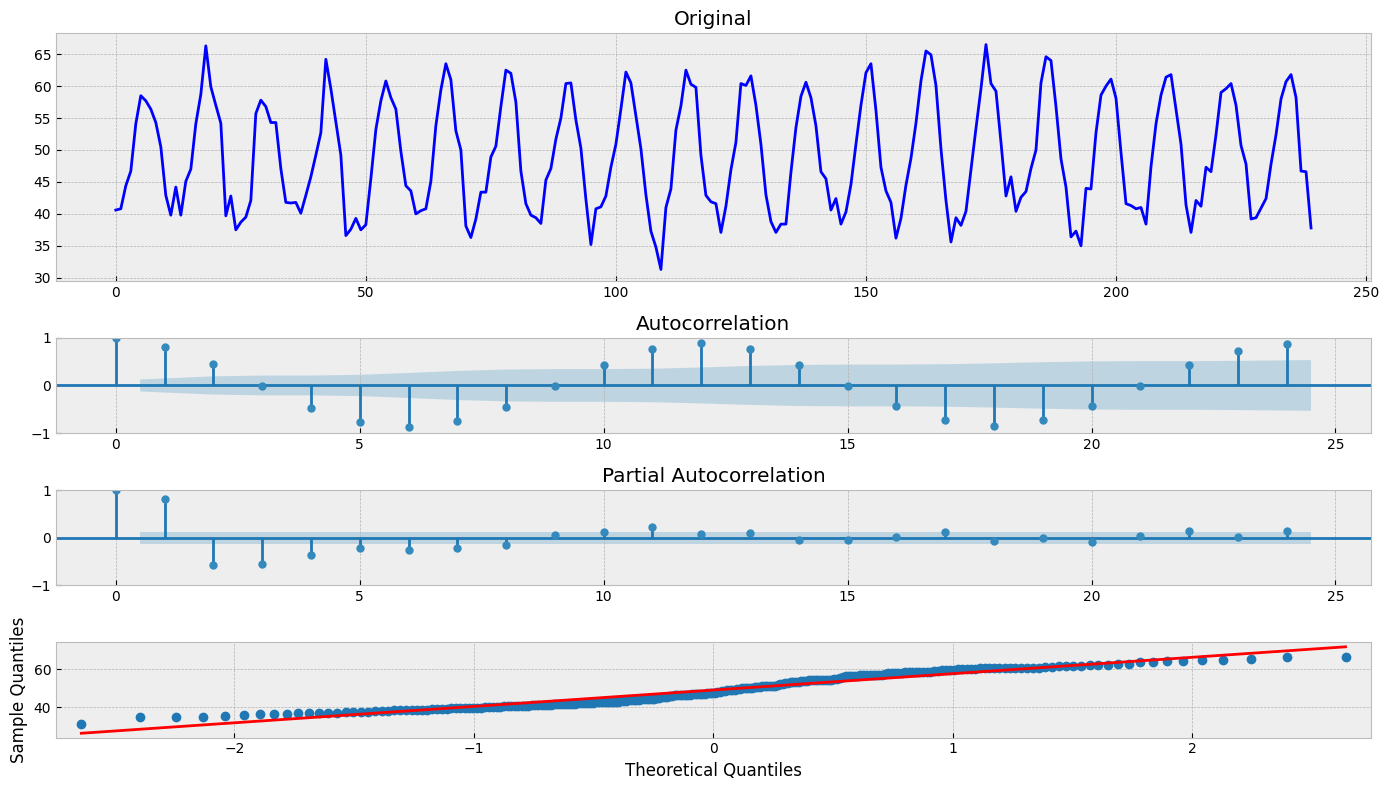

In [29]:
tsplot(series)

In [9]:
series = boxcox(series, 0)

In [30]:
# Поиск лучшей модели ARIMA
aic, order, mdl = _get_best_model(series)

Best model: aic: 1136.24457 | order: (3, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                  -5.601874
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


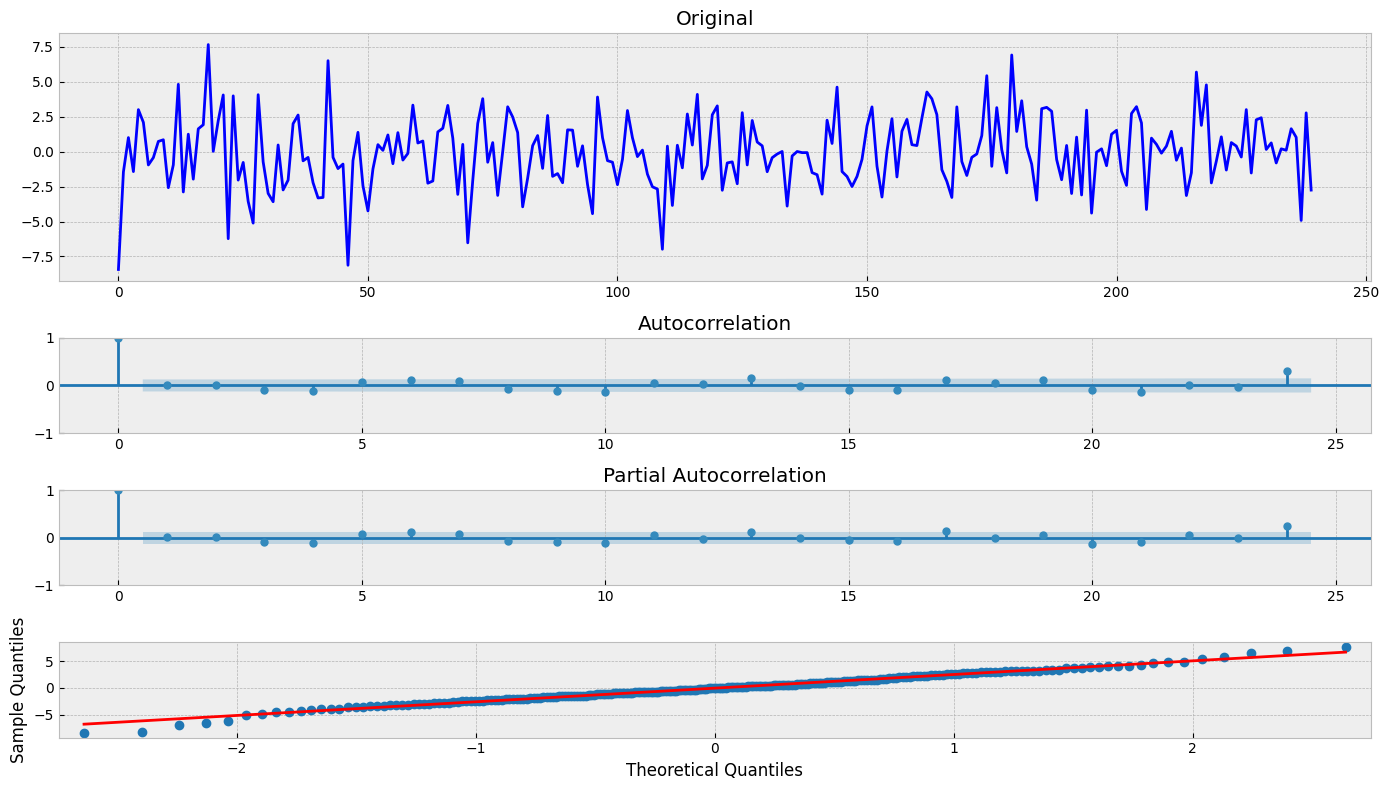

In [31]:
# График остатков
tsplot(mdl.resid)

In [32]:
# Применение модели GARCH к новой временной серии
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Использование распределения Стьюдента для улучшения подгонки
am = arch_model(series*100, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: 1964.8635112205636
Iteration:     10,   Func. Count:     95,   Neg. LLF: 1963.4403326301322
Iteration:     15,   Func. Count:    140,   Neg. LLF: 1961.2404133368557
Iteration:     20,   Func. Count:    185,   Neg. LLF: 1960.579137935734
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1960.5713901680622
            Iterations: 22
            Function evaluations: 213
            Gradient evaluations: 22
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          Deg   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1960.57
Distribution:      Standardized Student's t   AIC:                           3937.14
Method:                  Maximum Likelihood   BIC:                       

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


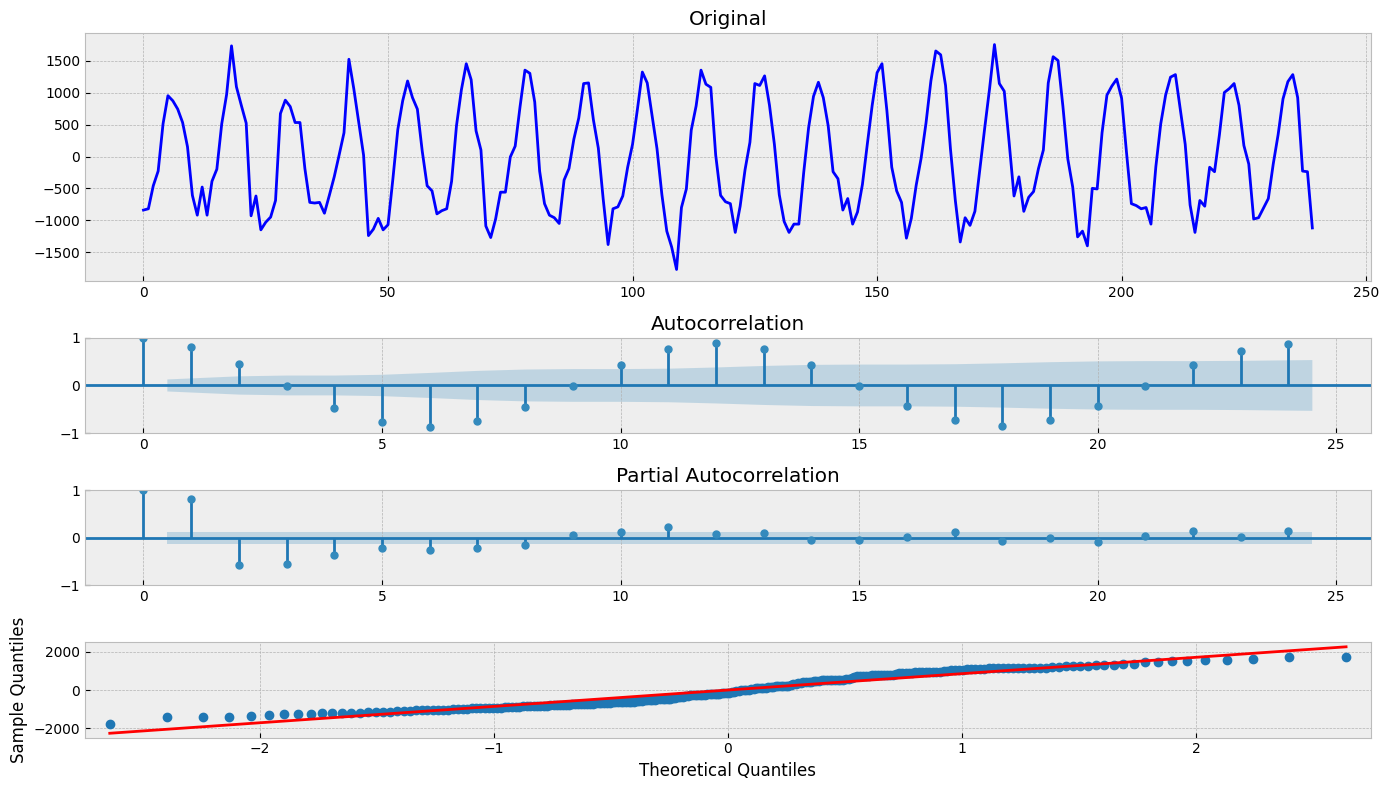

In [33]:
# Визуализация остатков модели GARCH
tsplot(res.resid)